In [47]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
print ('-This section done-')

import sys
sys.path.append("/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/Assignments/") 


-This section done-


In [48]:
#getting data
import weather
weather.maybe_download_and_extract()
cities = weather.cities
print(cities)
#%%time
df = weather.load_resampled_data()
print(df.head())

Data has apparently already been downloaded and unpacked.
['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']
                      Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      N

-This section done-


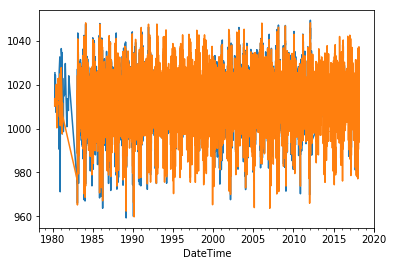

In [49]:
df['Esbjerg']['Pressure'].plot()
df['Roskilde']['Pressure'].plot()
df.values.shape
df.head(1)

df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print ('-This section done-')

In [50]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [51]:
# Converting Data Frames to Numpy array::::
x_data = df
print("X_Shape::::")
print(type(x_data))
print("Shape:", x_data.shape)

num_data = len(x_data)
print("# of input data ",num_data)
train_split = 1
num_train = int(train_split * num_data)
print("# of Training data: ",num_train)
x_train = x_data[0:num_train]
num_x_signals = x_data.shape[1]
print(num_x_signals)

X_Shape::::
<class 'pandas.core.frame.DataFrame'>
Shape: (333109, 20)
# of input data  333109
# of Training data:  333109
20


In [52]:
# Scaling data
#The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
#Data Generator
print(x_train_scaled.shape)


Min: 0.0
Max: 1.0000000000000002
(333109, 20)


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [53]:
lookback = 2352 # was 1440. 24 hours per day into 14 days = 168*14 = 2352
step = 6 # Original was 6
delay = 144 # We will predict 1 days in future. hence 24*6 = 144
batch_size = 128
#data—The original array of floating-point data
#lookback—How many timesteps back the input data should go.
#delay—How many timesteps in the future the target should be.
#min_index and max_index—Indices in the data array that delimit which time-
#steps to draw from. This is useful for keeping a segment of the data for valida-
#tion and another for testing.
#shuffle—Whether to shuffle the samples or draw them in chronological order.
#batch_size—The number of samples per batch.
#step—The period, in timesteps, at which you sample data. set it to 1 in
#order to draw one data point every hour.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1])) # Size = Batchsize,lookback,20
        targets = np.zeros((len(rows),)) #Size typically Batchsize
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        #print(np.shape(samples))
        #print(np.shape(targets))
        yield samples, targets

        
train_gen = generator(x_train_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)
val_steps = (30000 - 20001 - lookback)



In [64]:
import keras
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x_train_scaled.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=2, validation_data=val_gen, validation_steps=val_steps)
keras.models.save_model("model.h5")  # Save almost everything in one h5 file. What is missing:


Epoch 1/2


  1/500 [..............................] - ETA: 15:30 - loss: 0.5079

  3/500 [..............................] - ETA: 5:18 - loss: 10.0846

  4/500 [..............................] - ETA: 4:10 - loss: 8.7935 

  5/500 [..............................] - ETA: 3:27 - loss: 7.6873

  7/500 [..............................] - ETA: 2:31 - loss: 5.8305

 10/500 [..............................] - ETA: 1:48 - loss: 4.4848

 14/500 [..............................] - ETA: 1:18 - loss: 3.3685

 16/500 [..............................] - ETA: 1:10 - loss: 3.0196

 18/500 [>.............................] - ETA: 1:03 - loss: 2.7476

 21/500 [>.............................] - ETA: 56s - loss: 2.4357 

 23/500 [>.............................] - ETA: 52s - loss: 2.2722

 25/500 [>.............................] - ETA: 49s - loss: 2.1347

 27/500 [>.............................] - ETA: 46s - loss: 2.0176

 29/500 [>.............................] - ETA: 44s - loss: 1.9170

 31/500 [>.............................] - ETA: 41s - loss: 1.8288

 34/500 [=>............................] - ETA: 39s - loss: 1.7154

 37/500 [=>............................] - ETA: 36s - loss: 1.6215

 39/500 [=>............................] - ETA: 35s - loss: 1.5664

 41/500 [=>............................] - ETA: 34s - loss: 1.5170

 43/500 [=>............................] - ETA: 33s - loss: 1.4715

 46/500 [=>............................] - ETA: 31s - loss: 1.4117

 48/500 [=>............................] - ETA: 30s - loss: 1.3752

 50/500 [==>...........................] - ETA: 29s - loss: 1.3407

 52/500 [==>...........................] - ETA: 28s - loss: 1.3101

 54/500 [==>...........................] - ETA: 28s - loss: 1.2815

 56/500 [==>...........................] - ETA: 27s - loss: 1.2544

 58/500 [==>...........................] - ETA: 26s - loss: 1.2293

 60/500 [==>...........................] - ETA: 26s - loss: 1.2059

 62/500 [==>...........................] - ETA: 25s - loss: 1.1838

 64/500 [==>...........................] - ETA: 25s - loss: 1.1631

 66/500 [==>...........................] - ETA: 24s - loss: 1.1433

 68/500 [===>..........................] - ETA: 24s - loss: 1.1246

 70/500 [===>..........................] - ETA: 23s - loss: 1.1071

 72/500 [===>..........................] - ETA: 23s - loss: 1.0907

 74/500 [===>..........................] - ETA: 22s - loss: 1.0751

 76/500 [===>..........................] - ETA: 22s - loss: 1.0601

 78/500 [===>..........................] - ETA: 22s - loss: 1.0460

 81/500 [===>..........................] - ETA: 21s - loss: 1.0257

 83/500 [===>..........................] - ETA: 21s - loss: 1.0137

 85/500 [====>.........................] - ETA: 20s - loss: 1.0016

 87/500 [====>.........................] - ETA: 20s - loss: 0.9901

 89/500 [====>.........................] - ETA: 20s - loss: 0.9790

 91/500 [====>.........................] - ETA: 19s - loss: 0.9683

 93/500 [====>.........................] - ETA: 19s - loss: 0.9584

 96/500 [====>.........................] - ETA: 19s - loss: 0.9435

 98/500 [====>.........................] - ETA: 18s - loss: 0.9339

100/500 [=====>........................] - ETA: 18s - loss: 0.9247

102/500 [=====>........................] - ETA: 18s - loss: 0.9160

104/500 [=====>........................] - ETA: 18s - loss: 0.9077

106/500 [=====>........................] - ETA: 17s - loss: 0.8996

108/500 [=====>........................] - ETA: 17s - loss: 0.8914

110/500 [=====>........................] - ETA: 17s - loss: 0.8837

112/500 [=====>........................] - ETA: 17s - loss: 0.8764

114/500 [=====>........................] - ETA: 17s - loss: 0.8693

116/500 [=====>........................] - ETA: 16s - loss: 0.8625

119/500 [======>.......................] - ETA: 16s - loss: 0.8527

121/500 [======>.......................] - ETA: 16s - loss: 0.8464

123/500 [======>.......................] - ETA: 16s - loss: 0.8397

125/500 [======>.......................] - ETA: 16s - loss: 0.8338

127/500 [======>.......................] - ETA: 15s - loss: 0.8278

129/500 [======>.......................] - ETA: 15s - loss: 0.8221

131/500 [======>.......................] - ETA: 15s - loss: 0.8164

133/500 [======>.......................] - ETA: 15s - loss: 0.8108

135/500 [=======>......................] - ETA: 15s - loss: 0.8055

137/500 [=======>......................] - ETA: 15s - loss: 0.8005

139/500 [=======>......................] - ETA: 14s - loss: 0.7955

141/500 [=======>......................] - ETA: 14s - loss: 0.7903

143/500 [=======>......................] - ETA: 14s - loss: 0.7855

145/500 [=======>......................] - ETA: 14s - loss: 0.7806

148/500 [=======>......................] - ETA: 14s - loss: 0.7738

150/500 [========>.....................] - ETA: 14s - loss: 0.7691

153/500 [========>.....................] - ETA: 13s - loss: 0.7625

155/500 [========>.....................] - ETA: 13s - loss: 0.7581

157/500 [========>.....................] - ETA: 13s - loss: 0.7540

159/500 [========>.....................] - ETA: 13s - loss: 0.7499

161/500 [========>.....................] - ETA: 13s - loss: 0.7457

163/500 [========>.....................] - ETA: 13s - loss: 0.7417

165/500 [========>.....................] - ETA: 13s - loss: 0.7377

167/500 [=========>....................] - ETA: 12s - loss: 0.7338

169/500 [=========>....................] - ETA: 12s - loss: 0.7302

171/500 [=========>....................] - ETA: 12s - loss: 0.7264

173/500 [=========>....................] - ETA: 12s - loss: 0.7229

175/500 [=========>....................] - ETA: 12s - loss: 0.7193

177/500 [=========>....................] - ETA: 12s - loss: 0.7159

179/500 [=========>....................] - ETA: 12s - loss: 0.7126

181/500 [=========>....................] - ETA: 12s - loss: 0.7092

183/500 [=========>....................] - ETA: 11s - loss: 0.7058

185/500 [==========>...................] - ETA: 11s - loss: 0.7025

188/500 [==========>...................] - ETA: 11s - loss: 0.6977

190/500 [==========>...................] - ETA: 11s - loss: 0.6946

193/500 [==========>...................] - ETA: 11s - loss: 0.6897

195/500 [==========>...................] - ETA: 11s - loss: 0.6868

197/500 [==========>...................] - ETA: 11s - loss: 0.6838

199/500 [==========>...................] - ETA: 11s - loss: 0.6810

201/500 [===========>..................] - ETA: 10s - loss: 0.6779

203/500 [===========>..................] - ETA: 10s - loss: 0.6750

205/500 [===========>..................] - ETA: 10s - loss: 0.6721

207/500 [===========>..................] - ETA: 10s - loss: 0.6692

209/500 [===========>..................] - ETA: 10s - loss: 0.6664

211/500 [===========>..................] - ETA: 10s - loss: 0.6637

213/500 [===========>..................] - ETA: 10s - loss: 0.6609

215/500 [===========>..................] - ETA: 10s - loss: 0.6582

217/500 [============>.................] - ETA: 10s - loss: 0.6556

220/500 [============>.................] - ETA: 10s - loss: 0.6518

222/500 [============>.................] - ETA: 9s - loss: 0.6492 

224/500 [============>.................] - ETA: 9s - loss: 0.6465

226/500 [============>.................] - ETA: 9s - loss: 0.6440

228/500 [============>.................] - ETA: 9s - loss: 0.6413

230/500 [============>.................] - ETA: 9s - loss: 0.6390

232/500 [============>.................] - ETA: 9s - loss: 0.6366

234/500 [=============>................] - ETA: 9s - loss: 0.6340

236/500 [=============>................] - ETA: 9s - loss: 0.6316

238/500 [=============>................] - ETA: 9s - loss: 0.6292

240/500 [=============>................] - ETA: 9s - loss: 0.6268

242/500 [=============>................] - ETA: 9s - loss: 0.6244

244/500 [=============>................] - ETA: 8s - loss: 0.6220

246/500 [=============>................] - ETA: 8s - loss: 0.6197

248/500 [=============>................] - ETA: 8s - loss: 0.6175

250/500 [==============>...............] - ETA: 8s - loss: 0.6154

252/500 [==============>...............] - ETA: 8s - loss: 0.6132

254/500 [==============>...............] - ETA: 8s - loss: 0.6110

256/500 [==============>...............] - ETA: 8s - loss: 0.6087

258/500 [==============>...............] - ETA: 8s - loss: 0.6065

260/500 [==============>...............] - ETA: 8s - loss: 0.6042

262/500 [==============>...............] - ETA: 8s - loss: 0.6021

264/500 [==============>...............] - ETA: 8s - loss: 0.6000

266/500 [==============>...............] - ETA: 8s - loss: 0.5979

268/500 [===============>..............] - ETA: 7s - loss: 0.5958

270/500 [===============>..............] - ETA: 7s - loss: 0.5937

272/500 [===============>..............] - ETA: 7s - loss: 0.5917

274/500 [===============>..............] - ETA: 7s - loss: 0.5897

276/500 [===============>..............] - ETA: 7s - loss: 0.5877

279/500 [===============>..............] - ETA: 7s - loss: 0.5845

281/500 [===============>..............] - ETA: 7s - loss: 0.5825

283/500 [===============>..............] - ETA: 7s - loss: 0.5805

285/500 [================>.............] - ETA: 7s - loss: 0.5785

288/500 [================>.............] - ETA: 7s - loss: 0.5756

290/500 [================>.............] - ETA: 7s - loss: 0.5736

293/500 [================>.............] - ETA: 6s - loss: 0.5708

295/500 [================>.............] - ETA: 6s - loss: 0.5690

298/500 [================>.............] - ETA: 6s - loss: 0.5661

300/500 [=================>............] - ETA: 6s - loss: 0.5642

302/500 [=================>............] - ETA: 6s - loss: 0.5623

304/500 [=================>............] - ETA: 6s - loss: 0.5605

306/500 [=================>............] - ETA: 6s - loss: 0.5587

308/500 [=================>............] - ETA: 6s - loss: 0.5570

310/500 [=================>............] - ETA: 6s - loss: 0.5552

312/500 [=================>............] - ETA: 6s - loss: 0.5534

314/500 [=================>............] - ETA: 6s - loss: 0.5516

316/500 [=================>............] - ETA: 6s - loss: 0.5499

318/500 [==================>...........] - ETA: 6s - loss: 0.5482

320/500 [==================>...........] - ETA: 5s - loss: 0.5464

322/500 [==================>...........] - ETA: 5s - loss: 0.5447

325/500 [==================>...........] - ETA: 5s - loss: 0.5421

327/500 [==================>...........] - ETA: 5s - loss: 0.5403

329/500 [==================>...........] - ETA: 5s - loss: 0.5386

331/500 [==================>...........] - ETA: 5s - loss: 0.5369

334/500 [===================>..........] - ETA: 5s - loss: 0.5343

336/500 [===================>..........] - ETA: 5s - loss: 0.5327

338/500 [===================>..........] - ETA: 5s - loss: 0.5310

340/500 [===================>..........] - ETA: 5s - loss: 0.5294

342/500 [===================>..........] - ETA: 5s - loss: 0.5278

344/500 [===================>..........] - ETA: 5s - loss: 0.5262

346/500 [===================>..........] - ETA: 5s - loss: 0.5245

349/500 [===================>..........] - ETA: 4s - loss: 0.5221

351/500 [====================>.........] - ETA: 4s - loss: 0.5205

353/500 [====================>.........] - ETA: 4s - loss: 0.5188

355/500 [====================>.........] - ETA: 4s - loss: 0.5173

357/500 [====================>.........] - ETA: 4s - loss: 0.5157

359/500 [====================>.........] - ETA: 4s - loss: 0.5142

361/500 [====================>.........] - ETA: 4s - loss: 0.5126

363/500 [====================>.........] - ETA: 4s - loss: 0.5111

365/500 [====================>.........] - ETA: 4s - loss: 0.5095

367/500 [=====================>........] - ETA: 4s - loss: 0.5080

369/500 [=====================>........] - ETA: 4s - loss: 0.5065

372/500 [=====================>........] - ETA: 4s - loss: 0.5043

374/500 [=====================>........] - ETA: 4s - loss: 0.5028

376/500 [=====================>........] - ETA: 3s - loss: 0.5013

378/500 [=====================>........] - ETA: 3s - loss: 0.4998

380/500 [=====================>........] - ETA: 3s - loss: 0.4983

382/500 [=====================>........] - ETA: 3s - loss: 0.4969

384/500 [======================>.......] - ETA: 3s - loss: 0.4953

386/500 [======================>.......] - ETA: 3s - loss: 0.4939

388/500 [======================>.......] - ETA: 3s - loss: 0.4924

390/500 [======================>.......] - ETA: 3s - loss: 0.4909

392/500 [======================>.......] - ETA: 3s - loss: 0.4895

394/500 [======================>.......] - ETA: 3s - loss: 0.4880

396/500 [======================>.......] - ETA: 3s - loss: 0.4866

398/500 [======================>.......] - ETA: 3s - loss: 0.4851

400/500 [=======================>......] - ETA: 3s - loss: 0.4836

402/500 [=======================>......] - ETA: 3s - loss: 0.4822

404/500 [=======================>......] - ETA: 3s - loss: 0.4807

406/500 [=======================>......] - ETA: 2s - loss: 0.4793

408/500 [=======================>......] - ETA: 2s - loss: 0.4778

410/500 [=======================>......] - ETA: 2s - loss: 0.4764

412/500 [=======================>......] - ETA: 2s - loss: 0.4751

414/500 [=======================>......] - ETA: 2s - loss: 0.4736

416/500 [=======================>......] - ETA: 2s - loss: 0.4723

418/500 [========================>.....] - ETA: 2s - loss: 0.4709

420/500 [========================>.....] - ETA: 2s - loss: 0.4695

422/500 [========================>.....] - ETA: 2s - loss: 0.4682

424/500 [========================>.....] - ETA: 2s - loss: 0.4668

426/500 [========================>.....] - ETA: 2s - loss: 0.4655

428/500 [========================>.....] - ETA: 2s - loss: 0.4641

430/500 [========================>.....] - ETA: 2s - loss: 0.4627

432/500 [========================>.....] - ETA: 2s - loss: 0.4614

434/500 [=========================>....] - ETA: 2s - loss: 0.4600

436/500 [=========================>....] - ETA: 2s - loss: 0.4586

438/500 [=========================>....] - ETA: 1s - loss: 0.4574

441/500 [=========================>....] - ETA: 1s - loss: 0.4554

444/500 [=========================>....] - ETA: 1s - loss: 0.4534

446/500 [=========================>....] - ETA: 1s - loss: 0.4521

448/500 [=========================>....] - ETA: 1s - loss: 0.4508

450/500 [==========================>...] - ETA: 1s - loss: 0.4495

452/500 [==========================>...] - ETA: 1s - loss: 0.4482

455/500 [==========================>...] - ETA: 1s - loss: 0.4463

457/500 [==========================>...] - ETA: 1s - loss: 0.4450

459/500 [==========================>...] - ETA: 1s - loss: 0.4438

461/500 [==========================>...] - ETA: 1s - loss: 0.4425

463/500 [==========================>...] - ETA: 1s - loss: 0.4413

465/500 [==========================>...] - ETA: 1s - loss: 0.4400

467/500 [===========================>..] - ETA: 1s - loss: 0.4388

469/500 [===========================>..] - ETA: 0s - loss: 0.4376

471/500 [===========================>..] - ETA: 0s - loss: 0.4364

473/500 [===========================>..] - ETA: 0s - loss: 0.4352

475/500 [===========================>..] - ETA: 0s - loss: 0.4339

477/500 [===========================>..] - ETA: 0s - loss: 0.4327

479/500 [===========================>..] - ETA: 0s - loss: 0.4315

481/500 [===========================>..] - ETA: 0s - loss: 0.4304

484/500 [============================>.] - ETA: 0s - loss: 0.4285

487/500 [============================>.] - ETA: 0s - loss: 0.4267

489/500 [============================>.] - ETA: 0s - loss: 0.4255

491/500 [============================>.] - ETA: 0s - loss: 0.4244

493/500 [============================>.] - ETA: 0s - loss: 0.4231

495/500 [============================>.] - ETA: 0s - loss: 0.4220

497/500 [============================>.] - ETA: 0s - loss: 0.4209

499/500 [============================>.] - ETA: 0s - loss: 0.4197

500/500 [==============================] - 151s 302ms/step - loss: 0.4191 - val_loss: 0.1110


Epoch 2/2
  1/500 [..............................] - ETA: 15s - loss: 0.1292

  4/500 [..............................] - ETA: 11s - loss: 0.1246

  7/500 [..............................] - ETA: 10s - loss: 0.1296

 11/500 [..............................] - ETA: 9s - loss: 0.1306 

 14/500 [..............................] - ETA: 10s - loss: 0.1297

 15/500 [..............................] - ETA: 12s - loss: 0.1302

 17/500 [>.............................] - ETA: 13s - loss: 0.1297

 19/500 [>.............................] - ETA: 13s - loss: 0.1300

 21/500 [>.............................] - ETA: 13s - loss: 0.1309

 23/500 [>.............................] - ETA: 13s - loss: 0.1306

 25/500 [>.............................] - ETA: 13s - loss: 0.1298

 27/500 [>.............................] - ETA: 13s - loss: 0.1297

 29/500 [>.............................] - ETA: 13s - loss: 0.1292

 31/500 [>.............................] - ETA: 12s - loss: 0.1290

 33/500 [>.............................] - ETA: 12s - loss: 0.1287

 35/500 [=>............................] - ETA: 12s - loss: 0.1284

 37/500 [=>............................] - ETA: 12s - loss: 0.1278

 38/500 [=>............................] - ETA: 13s - loss: 0.1275

 40/500 [=>............................] - ETA: 13s - loss: 0.1268

 42/500 [=>............................] - ETA: 13s - loss: 0.1263

 44/500 [=>............................] - ETA: 12s - loss: 0.1259

 46/500 [=>............................] - ETA: 12s - loss: 0.1250

 48/500 [=>............................] - ETA: 12s - loss: 0.1248

 50/500 [==>...........................] - ETA: 12s - loss: 0.1247

 52/500 [==>...........................] - ETA: 12s - loss: 0.1246

 54/500 [==>...........................] - ETA: 12s - loss: 0.1244

 56/500 [==>...........................] - ETA: 12s - loss: 0.1243

 58/500 [==>...........................] - ETA: 12s - loss: 0.1241

 60/500 [==>...........................] - ETA: 12s - loss: 0.1240

 62/500 [==>...........................] - ETA: 12s - loss: 0.1239

 64/500 [==>...........................] - ETA: 12s - loss: 0.1234

 66/500 [==>...........................] - ETA: 12s - loss: 0.1232

 68/500 [===>..........................] - ETA: 12s - loss: 0.1229

 70/500 [===>..........................] - ETA: 12s - loss: 0.1227

 72/500 [===>..........................] - ETA: 12s - loss: 0.1227

 74/500 [===>..........................] - ETA: 12s - loss: 0.1226

 77/500 [===>..........................] - ETA: 12s - loss: 0.1218

 79/500 [===>..........................] - ETA: 12s - loss: 0.1218

 82/500 [===>..........................] - ETA: 11s - loss: 0.1217

 84/500 [====>.........................] - ETA: 11s - loss: 0.1216

 86/500 [====>.........................] - ETA: 11s - loss: 0.1214

 88/500 [====>.........................] - ETA: 11s - loss: 0.1212

 90/500 [====>.........................] - ETA: 11s - loss: 0.1212

 92/500 [====>.........................] - ETA: 11s - loss: 0.1210

 94/500 [====>.........................] - ETA: 11s - loss: 0.1210

 96/500 [====>.........................] - ETA: 11s - loss: 0.1210

 98/500 [====>.........................] - ETA: 11s - loss: 0.1210

100/500 [=====>........................] - ETA: 11s - loss: 0.1210

102/500 [=====>........................] - ETA: 11s - loss: 0.1210

104/500 [=====>........................] - ETA: 11s - loss: 0.1207

106/500 [=====>........................] - ETA: 11s - loss: 0.1206

108/500 [=====>........................] - ETA: 11s - loss: 0.1205

110/500 [=====>........................] - ETA: 11s - loss: 0.1204

112/500 [=====>........................] - ETA: 11s - loss: 0.1202

114/500 [=====>........................] - ETA: 10s - loss: 0.1201

116/500 [=====>........................] - ETA: 10s - loss: 0.1200

118/500 [======>.......................] - ETA: 10s - loss: 0.1198

120/500 [======>.......................] - ETA: 10s - loss: 0.1198

122/500 [======>.......................] - ETA: 10s - loss: 0.1196

124/500 [======>.......................] - ETA: 10s - loss: 0.1194

126/500 [======>.......................] - ETA: 10s - loss: 0.1192

128/500 [======>.......................] - ETA: 10s - loss: 0.1191

130/500 [======>.......................] - ETA: 10s - loss: 0.1190

132/500 [======>.......................] - ETA: 10s - loss: 0.1189

134/500 [=======>......................] - ETA: 10s - loss: 0.1188

136/500 [=======>......................] - ETA: 10s - loss: 0.1187

138/500 [=======>......................] - ETA: 10s - loss: 0.1187

140/500 [=======>......................] - ETA: 10s - loss: 0.1185

143/500 [=======>......................] - ETA: 10s - loss: 0.1185

145/500 [=======>......................] - ETA: 10s - loss: 0.1184

148/500 [=======>......................] - ETA: 10s - loss: 0.1183

150/500 [========>.....................] - ETA: 10s - loss: 0.1181

152/500 [========>.....................] - ETA: 9s - loss: 0.1181 

154/500 [========>.....................] - ETA: 9s - loss: 0.1180

156/500 [========>.....................] - ETA: 9s - loss: 0.1180

158/500 [========>.....................] - ETA: 9s - loss: 0.1180

160/500 [========>.....................] - ETA: 9s - loss: 0.1180

162/500 [========>.....................] - ETA: 9s - loss: 0.1179

164/500 [========>.....................] - ETA: 9s - loss: 0.1177

166/500 [========>.....................] - ETA: 9s - loss: 0.1177

168/500 [=========>....................] - ETA: 9s - loss: 0.1177

170/500 [=========>....................] - ETA: 9s - loss: 0.1177

172/500 [=========>....................] - ETA: 9s - loss: 0.1176

174/500 [=========>....................] - ETA: 9s - loss: 0.1175

176/500 [=========>....................] - ETA: 9s - loss: 0.1175

178/500 [=========>....................] - ETA: 9s - loss: 0.1175

180/500 [=========>....................] - ETA: 9s - loss: 0.1175

182/500 [=========>....................] - ETA: 9s - loss: 0.1174

184/500 [==========>...................] - ETA: 9s - loss: 0.1173

186/500 [==========>...................] - ETA: 9s - loss: 0.1173

188/500 [==========>...................] - ETA: 8s - loss: 0.1172

190/500 [==========>...................] - ETA: 8s - loss: 0.1171

192/500 [==========>...................] - ETA: 8s - loss: 0.1171

194/500 [==========>...................] - ETA: 8s - loss: 0.1171

196/500 [==========>...................] - ETA: 8s - loss: 0.1170

198/500 [==========>...................] - ETA: 8s - loss: 0.1169

200/500 [===========>..................] - ETA: 8s - loss: 0.1169

202/500 [===========>..................] - ETA: 8s - loss: 0.1168

204/500 [===========>..................] - ETA: 8s - loss: 0.1168

206/500 [===========>..................] - ETA: 8s - loss: 0.1168

208/500 [===========>..................] - ETA: 8s - loss: 0.1169

210/500 [===========>..................] - ETA: 8s - loss: 0.1169

212/500 [===========>..................] - ETA: 8s - loss: 0.1168

213/500 [===========>..................] - ETA: 8s - loss: 0.1168

214/500 [===========>..................] - ETA: 8s - loss: 0.1168

215/500 [===========>..................] - ETA: 8s - loss: 0.1168

217/500 [============>.................] - ETA: 8s - loss: 0.1168

218/500 [============>.................] - ETA: 8s - loss: 0.1168

219/500 [============>.................] - ETA: 8s - loss: 0.1167

221/500 [============>.................] - ETA: 8s - loss: 0.1166

222/500 [============>.................] - ETA: 8s - loss: 0.1166

223/500 [============>.................] - ETA: 8s - loss: 0.1166

224/500 [============>.................] - ETA: 8s - loss: 0.1166

226/500 [============>.................] - ETA: 8s - loss: 0.1164

228/500 [============>.................] - ETA: 8s - loss: 0.1164

229/500 [============>.................] - ETA: 8s - loss: 0.1164

231/500 [============>.................] - ETA: 8s - loss: 0.1164

233/500 [============>.................] - ETA: 8s - loss: 0.1164

235/500 [=============>................] - ETA: 8s - loss: 0.1163

237/500 [=============>................] - ETA: 8s - loss: 0.1164

239/500 [=============>................] - ETA: 8s - loss: 0.1164

241/500 [=============>................] - ETA: 8s - loss: 0.1164

243/500 [=============>................] - ETA: 8s - loss: 0.1164

245/500 [=============>................] - ETA: 8s - loss: 0.1164

247/500 [=============>................] - ETA: 7s - loss: 0.1163

249/500 [=============>................] - ETA: 7s - loss: 0.1163

251/500 [==============>...............] - ETA: 7s - loss: 0.1164

253/500 [==============>...............] - ETA: 7s - loss: 0.1163

255/500 [==============>...............] - ETA: 7s - loss: 0.1163

257/500 [==============>...............] - ETA: 7s - loss: 0.1163

259/500 [==============>...............] - ETA: 7s - loss: 0.1162

261/500 [==============>...............] - ETA: 7s - loss: 0.1162

263/500 [==============>...............] - ETA: 7s - loss: 0.1162

265/500 [==============>...............] - ETA: 7s - loss: 0.1162

267/500 [===============>..............] - ETA: 7s - loss: 0.1161

269/500 [===============>..............] - ETA: 7s - loss: 0.1161

271/500 [===============>..............] - ETA: 7s - loss: 0.1161

273/500 [===============>..............] - ETA: 7s - loss: 0.1161

275/500 [===============>..............] - ETA: 6s - loss: 0.1161

277/500 [===============>..............] - ETA: 6s - loss: 0.1161

279/500 [===============>..............] - ETA: 6s - loss: 0.1161

281/500 [===============>..............] - ETA: 6s - loss: 0.1160

283/500 [===============>..............] - ETA: 6s - loss: 0.1160

285/500 [================>.............] - ETA: 6s - loss: 0.1160

287/500 [================>.............] - ETA: 6s - loss: 0.1160

289/500 [================>.............] - ETA: 6s - loss: 0.1160

291/500 [================>.............] - ETA: 6s - loss: 0.1160

293/500 [================>.............] - ETA: 6s - loss: 0.1160

295/500 [================>.............] - ETA: 6s - loss: 0.1160

297/500 [================>.............] - ETA: 6s - loss: 0.1160

299/500 [================>.............] - ETA: 6s - loss: 0.1159

301/500 [=================>............] - ETA: 6s - loss: 0.1159

303/500 [=================>............] - ETA: 6s - loss: 0.1159

305/500 [=================>............] - ETA: 6s - loss: 0.1159

307/500 [=================>............] - ETA: 5s - loss: 0.1159

309/500 [=================>............] - ETA: 5s - loss: 0.1159

312/500 [=================>............] - ETA: 5s - loss: 0.1159

314/500 [=================>............] - ETA: 5s - loss: 0.1159

316/500 [=================>............] - ETA: 5s - loss: 0.1158

319/500 [==================>...........] - ETA: 5s - loss: 0.1159

321/500 [==================>...........] - ETA: 5s - loss: 0.1158

323/500 [==================>...........] - ETA: 5s - loss: 0.1158

325/500 [==================>...........] - ETA: 5s - loss: 0.1159

327/500 [==================>...........] - ETA: 5s - loss: 0.1159

329/500 [==================>...........] - ETA: 5s - loss: 0.1158

331/500 [==================>...........] - ETA: 5s - loss: 0.1159

333/500 [==================>...........] - ETA: 5s - loss: 0.1158

335/500 [===================>..........] - ETA: 5s - loss: 0.1158

337/500 [===================>..........] - ETA: 4s - loss: 0.1158

339/500 [===================>..........] - ETA: 4s - loss: 0.1157

341/500 [===================>..........] - ETA: 4s - loss: 0.1157

343/500 [===================>..........] - ETA: 4s - loss: 0.1157

345/500 [===================>..........] - ETA: 4s - loss: 0.1157

347/500 [===================>..........] - ETA: 4s - loss: 0.1157

349/500 [===================>..........] - ETA: 4s - loss: 0.1157

351/500 [====================>.........] - ETA: 4s - loss: 0.1157

353/500 [====================>.........] - ETA: 4s - loss: 0.1157

355/500 [====================>.........] - ETA: 4s - loss: 0.1157

357/500 [====================>.........] - ETA: 4s - loss: 0.1156

359/500 [====================>.........] - ETA: 4s - loss: 0.1156

361/500 [====================>.........] - ETA: 4s - loss: 0.1156

363/500 [====================>.........] - ETA: 4s - loss: 0.1156

365/500 [====================>.........] - ETA: 4s - loss: 0.1156

367/500 [=====================>........] - ETA: 4s - loss: 0.1155

369/500 [=====================>........] - ETA: 3s - loss: 0.1156

370/500 [=====================>........] - ETA: 3s - loss: 0.1156

372/500 [=====================>........] - ETA: 3s - loss: 0.1155

374/500 [=====================>........] - ETA: 3s - loss: 0.1155

376/500 [=====================>........] - ETA: 3s - loss: 0.1155

378/500 [=====================>........] - ETA: 3s - loss: 0.1155

380/500 [=====================>........] - ETA: 3s - loss: 0.1155

382/500 [=====================>........] - ETA: 3s - loss: 0.1155

384/500 [======================>.......] - ETA: 3s - loss: 0.1155

386/500 [======================>.......] - ETA: 3s - loss: 0.1154

388/500 [======================>.......] - ETA: 3s - loss: 0.1154

390/500 [======================>.......] - ETA: 3s - loss: 0.1154

392/500 [======================>.......] - ETA: 3s - loss: 0.1154

394/500 [======================>.......] - ETA: 3s - loss: 0.1154

396/500 [======================>.......] - ETA: 3s - loss: 0.1154

398/500 [======================>.......] - ETA: 3s - loss: 0.1154

400/500 [=======================>......] - ETA: 3s - loss: 0.1154

402/500 [=======================>......] - ETA: 2s - loss: 0.1154

404/500 [=======================>......] - ETA: 2s - loss: 0.1154

405/500 [=======================>......] - ETA: 2s - loss: 0.1154

407/500 [=======================>......] - ETA: 2s - loss: 0.1154

409/500 [=======================>......] - ETA: 2s - loss: 0.1154

411/500 [=======================>......] - ETA: 2s - loss: 0.1154

414/500 [=======================>......] - ETA: 2s - loss: 0.1154

416/500 [=======================>......] - ETA: 2s - loss: 0.1154

418/500 [========================>.....] - ETA: 2s - loss: 0.1154

420/500 [========================>.....] - ETA: 2s - loss: 0.1154

422/500 [========================>.....] - ETA: 2s - loss: 0.1154

425/500 [========================>.....] - ETA: 2s - loss: 0.1153

427/500 [========================>.....] - ETA: 2s - loss: 0.1153

429/500 [========================>.....] - ETA: 2s - loss: 0.1153

431/500 [========================>.....] - ETA: 2s - loss: 0.1153

433/500 [========================>.....] - ETA: 2s - loss: 0.1152

435/500 [=========================>....] - ETA: 1s - loss: 0.1152

437/500 [=========================>....] - ETA: 1s - loss: 0.1153

439/500 [=========================>....] - ETA: 1s - loss: 0.1153

441/500 [=========================>....] - ETA: 1s - loss: 0.1153

443/500 [=========================>....] - ETA: 1s - loss: 0.1153

445/500 [=========================>....] - ETA: 1s - loss: 0.1152

447/500 [=========================>....] - ETA: 1s - loss: 0.1152

449/500 [=========================>....] - ETA: 1s - loss: 0.1151

451/500 [==========================>...] - ETA: 1s - loss: 0.1151

453/500 [==========================>...] - ETA: 1s - loss: 0.1151

455/500 [==========================>...] - ETA: 1s - loss: 0.1151

457/500 [==========================>...] - ETA: 1s - loss: 0.1151

460/500 [==========================>...] - ETA: 1s - loss: 0.1151

462/500 [==========================>...] - ETA: 1s - loss: 0.1151

464/500 [==========================>...] - ETA: 1s - loss: 0.1151

466/500 [==========================>...] - ETA: 1s - loss: 0.1150

468/500 [===========================>..] - ETA: 0s - loss: 0.1150

470/500 [===========================>..] - ETA: 0s - loss: 0.1150

472/500 [===========================>..] - ETA: 0s - loss: 0.1150

474/500 [===========================>..] - ETA: 0s - loss: 0.1150

476/500 [===========================>..] - ETA: 0s - loss: 0.1150

478/500 [===========================>..] - ETA: 0s - loss: 0.1150

480/500 [===========================>..] - ETA: 0s - loss: 0.1150

482/500 [===========================>..] - ETA: 0s - loss: 0.1150

484/500 [============================>.] - ETA: 0s - loss: 0.1150

486/500 [============================>.] - ETA: 0s - loss: 0.1150

488/500 [============================>.] - ETA: 0s - loss: 0.1150

490/500 [============================>.] - ETA: 0s - loss: 0.1150

492/500 [============================>.] - ETA: 0s - loss: 0.1150

494/500 [============================>.] - ETA: 0s - loss: 0.1150

496/500 [============================>.] - ETA: 0s - loss: 0.1150

498/500 [============================>.] - ETA: 0s - loss: 0.1150

500/500 [==============================] - 158s 317ms/step - loss: 0.1150 - val_loss: 0.0882


TypeError: save_model() missing 1 required positional argument: 'filepath'

In [66]:
dropout = 0.2
import keras
from keras.layers import LSTM
from keras.models import Sequential 
from keras import layers
from keras.callbacks import EarlyStopping, CSVLogger
model = Sequential()
# We will be adding LSTM cell from Keras.
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lookback// step, x_train_scaled.shape[-1]),
               stateful=True, dropout=dropout))
model.add(layers.Dense(1))
early_stop = EarlyStopping(patience=2, mode='max')
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=1, validation_data=val_gen, validation_steps=val_steps,callbacks=[early_stop])
# make predictions
keras.models.save_model(model,"/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/"
                        "Assignments/model.h5")  # Save almost everything in one h5 file. What is missing:

#trainPredict = model.predict(train_gen, batch_size=batch_size)


Epoch 1/1


  1/500 [..............................] - ETA: 18:34 - loss: 0.2274

  2/500 [..............................] - ETA: 10:06 - loss: 0.2393

  3/500 [..............................] - ETA: 7:16 - loss: 0.2456 

  4/500 [..............................] - ETA: 5:51 - loss: 0.2391

  5/500 [..............................] - ETA: 4:58 - loss: 0.2280

  6/500 [..............................] - ETA: 4:24 - loss: 0.2263

  7/500 [..............................] - ETA: 4:01 - loss: 0.2233

  8/500 [..............................] - ETA: 3:43 - loss: 0.2202

  9/500 [..............................] - ETA: 3:28 - loss: 0.2122

 10/500 [..............................] - ETA: 3:16 - loss: 0.2052

 11/500 [..............................] - ETA: 3:06 - loss: 0.1991

 12/500 [..............................] - ETA: 2:58 - loss: 0.1934

 13/500 [..............................] - ETA: 2:51 - loss: 0.1891

 14/500 [..............................] - ETA: 2:45 - loss: 0.1840

 15/500 [..............................] - ETA: 2:39 - loss: 0.1782

 16/500 [..............................] - ETA: 2:35 - loss: 0.1753

 17/500 [>.............................] - ETA: 2:31 - loss: 0.1710

 18/500 [>.............................] - ETA: 2:28 - loss: 0.1666

 19/500 [>.............................] - ETA: 2:25 - loss: 0.1620

 20/500 [>.............................] - ETA: 2:21 - loss: 0.1569

 21/500 [>.............................] - ETA: 2:19 - loss: 0.1528

 22/500 [>.............................] - ETA: 2:16 - loss: 0.1490

 23/500 [>.............................] - ETA: 2:14 - loss: 0.1448

 24/500 [>.............................] - ETA: 2:11 - loss: 0.1419

 25/500 [>.............................] - ETA: 2:09 - loss: 0.1383

 26/500 [>.............................] - ETA: 2:08 - loss: 0.1351

 27/500 [>.............................] - ETA: 2:06 - loss: 0.1323

 28/500 [>.............................] - ETA: 2:05 - loss: 0.1296

 29/500 [>.............................] - ETA: 2:03 - loss: 0.1267

 30/500 [>.............................] - ETA: 2:02 - loss: 0.1242

 31/500 [>.............................] - ETA: 2:01 - loss: 0.1215

 32/500 [>.............................] - ETA: 1:59 - loss: 0.1189

 33/500 [>.............................] - ETA: 1:58 - loss: 0.1166

 34/500 [=>............................] - ETA: 1:57 - loss: 0.1144

 35/500 [=>............................] - ETA: 1:56 - loss: 0.1130

 36/500 [=>............................] - ETA: 1:55 - loss: 0.1108

 37/500 [=>............................] - ETA: 1:54 - loss: 0.1089

 38/500 [=>............................] - ETA: 1:53 - loss: 0.1078

 39/500 [=>............................] - ETA: 1:52 - loss: 0.1063

 40/500 [=>............................] - ETA: 1:51 - loss: 0.1049

 41/500 [=>............................] - ETA: 1:50 - loss: 0.1034

 42/500 [=>............................] - ETA: 1:50 - loss: 0.1018

 43/500 [=>............................] - ETA: 1:49 - loss: 0.1002

 44/500 [=>............................] - ETA: 1:48 - loss: 0.0987

 45/500 [=>............................] - ETA: 1:48 - loss: 0.0975

 46/500 [=>............................] - ETA: 1:47 - loss: 0.0959

 47/500 [=>............................] - ETA: 1:46 - loss: 0.0947

 48/500 [=>............................] - ETA: 1:46 - loss: 0.0934

 49/500 [=>............................] - ETA: 1:45 - loss: 0.0922

 50/500 [==>...........................] - ETA: 1:44 - loss: 0.0915

 51/500 [==>...........................] - ETA: 1:44 - loss: 0.0901

 52/500 [==>...........................] - ETA: 1:43 - loss: 0.0889

 53/500 [==>...........................] - ETA: 1:43 - loss: 0.0878

 54/500 [==>...........................] - ETA: 1:42 - loss: 0.0868

 55/500 [==>...........................] - ETA: 1:42 - loss: 0.0857

 56/500 [==>...........................] - ETA: 1:42 - loss: 0.0848

 57/500 [==>...........................] - ETA: 1:41 - loss: 0.0839

 58/500 [==>...........................] - ETA: 1:40 - loss: 0.0830

 59/500 [==>...........................] - ETA: 1:40 - loss: 0.0822

 60/500 [==>...........................] - ETA: 1:39 - loss: 0.0814

 61/500 [==>...........................] - ETA: 1:39 - loss: 0.0805

 62/500 [==>...........................] - ETA: 1:38 - loss: 0.0798

 63/500 [==>...........................] - ETA: 1:38 - loss: 0.0790

 64/500 [==>...........................] - ETA: 1:37 - loss: 0.0782

 65/500 [==>...........................] - ETA: 1:37 - loss: 0.0775

 66/500 [==>...........................] - ETA: 1:36 - loss: 0.0768

 67/500 [===>..........................] - ETA: 1:36 - loss: 0.0762

 68/500 [===>..........................] - ETA: 1:35 - loss: 0.0754

 69/500 [===>..........................] - ETA: 1:35 - loss: 0.0747

 70/500 [===>..........................] - ETA: 1:35 - loss: 0.0740

 71/500 [===>..........................] - ETA: 1:34 - loss: 0.0732

 72/500 [===>..........................] - ETA: 1:34 - loss: 0.0726

 73/500 [===>..........................] - ETA: 1:33 - loss: 0.0719

 74/500 [===>..........................] - ETA: 1:33 - loss: 0.0713

 75/500 [===>..........................] - ETA: 1:32 - loss: 0.0707

 76/500 [===>..........................] - ETA: 1:32 - loss: 0.0701

 77/500 [===>..........................] - ETA: 1:32 - loss: 0.0696

 78/500 [===>..........................] - ETA: 1:31 - loss: 0.0691

 79/500 [===>..........................] - ETA: 1:31 - loss: 0.0685

 80/500 [===>..........................] - ETA: 1:31 - loss: 0.0679

 81/500 [===>..........................] - ETA: 1:31 - loss: 0.0674

 82/500 [===>..........................] - ETA: 1:30 - loss: 0.0669

 83/500 [===>..........................] - ETA: 1:30 - loss: 0.0664

 84/500 [====>.........................] - ETA: 1:30 - loss: 0.0660

 85/500 [====>.........................] - ETA: 1:29 - loss: 0.0655

 86/500 [====>.........................] - ETA: 1:29 - loss: 0.0650

 87/500 [====>.........................] - ETA: 1:29 - loss: 0.0646

 88/500 [====>.........................] - ETA: 1:29 - loss: 0.0642

 89/500 [====>.........................] - ETA: 1:28 - loss: 0.0638

 90/500 [====>.........................] - ETA: 1:28 - loss: 0.0634

 91/500 [====>.........................] - ETA: 1:27 - loss: 0.0630

 92/500 [====>.........................] - ETA: 1:27 - loss: 0.0625

 93/500 [====>.........................] - ETA: 1:27 - loss: 0.0621

 94/500 [====>.........................] - ETA: 1:27 - loss: 0.0617

 95/500 [====>.........................] - ETA: 1:26 - loss: 0.0613

 96/500 [====>.........................] - ETA: 1:26 - loss: 0.0609

 97/500 [====>.........................] - ETA: 1:26 - loss: 0.0606

 98/500 [====>.........................] - ETA: 1:25 - loss: 0.0602

 99/500 [====>.........................] - ETA: 1:25 - loss: 0.0599

100/500 [=====>........................] - ETA: 1:25 - loss: 0.0595

101/500 [=====>........................] - ETA: 1:24 - loss: 0.0591

102/500 [=====>........................] - ETA: 1:24 - loss: 0.0587

103/500 [=====>........................] - ETA: 1:24 - loss: 0.0585

104/500 [=====>........................] - ETA: 1:23 - loss: 0.0582

105/500 [=====>........................] - ETA: 1:23 - loss: 0.0579

106/500 [=====>........................] - ETA: 1:23 - loss: 0.0576

107/500 [=====>........................] - ETA: 1:22 - loss: 0.0573

108/500 [=====>........................] - ETA: 1:22 - loss: 0.0569

109/500 [=====>........................] - ETA: 1:22 - loss: 0.0567

110/500 [=====>........................] - ETA: 1:22 - loss: 0.0563

111/500 [=====>........................] - ETA: 1:21 - loss: 0.0560

112/500 [=====>........................] - ETA: 1:21 - loss: 0.0557

113/500 [=====>........................] - ETA: 1:21 - loss: 0.0554

114/500 [=====>........................] - ETA: 1:20 - loss: 0.0551

115/500 [=====>........................] - ETA: 1:20 - loss: 0.0549

116/500 [=====>........................] - ETA: 1:20 - loss: 0.0546

117/500 [======>.......................] - ETA: 1:20 - loss: 0.0543

118/500 [======>.......................] - ETA: 1:19 - loss: 0.0540

119/500 [======>.......................] - ETA: 1:19 - loss: 0.0538

120/500 [======>.......................] - ETA: 1:19 - loss: 0.0536

121/500 [======>.......................] - ETA: 1:19 - loss: 0.0534

122/500 [======>.......................] - ETA: 1:18 - loss: 0.0532

123/500 [======>.......................] - ETA: 1:18 - loss: 0.0530

124/500 [======>.......................] - ETA: 1:18 - loss: 0.0528

125/500 [======>.......................] - ETA: 1:17 - loss: 0.0526

126/500 [======>.......................] - ETA: 1:17 - loss: 0.0523

127/500 [======>.......................] - ETA: 1:17 - loss: 0.0521

128/500 [======>.......................] - ETA: 1:17 - loss: 0.0520

129/500 [======>.......................] - ETA: 1:16 - loss: 0.0518

130/500 [======>.......................] - ETA: 1:16 - loss: 0.0516

131/500 [======>.......................] - ETA: 1:16 - loss: 0.0514

132/500 [======>.......................] - ETA: 1:16 - loss: 0.0511

133/500 [======>.......................] - ETA: 1:15 - loss: 0.0509

134/500 [=======>......................] - ETA: 1:15 - loss: 0.0508

135/500 [=======>......................] - ETA: 1:15 - loss: 0.0506

136/500 [=======>......................] - ETA: 1:15 - loss: 0.0504

137/500 [=======>......................] - ETA: 1:14 - loss: 0.0502

138/500 [=======>......................] - ETA: 1:14 - loss: 0.0500

139/500 [=======>......................] - ETA: 1:14 - loss: 0.0499

140/500 [=======>......................] - ETA: 1:14 - loss: 0.0497

141/500 [=======>......................] - ETA: 1:13 - loss: 0.0495

142/500 [=======>......................] - ETA: 1:13 - loss: 0.0493

143/500 [=======>......................] - ETA: 1:13 - loss: 0.0491

144/500 [=======>......................] - ETA: 1:13 - loss: 0.0489

145/500 [=======>......................] - ETA: 1:12 - loss: 0.0487

146/500 [=======>......................] - ETA: 1:12 - loss: 0.0486

147/500 [=======>......................] - ETA: 1:12 - loss: 0.0485

148/500 [=======>......................] - ETA: 1:12 - loss: 0.0483

149/500 [=======>......................] - ETA: 1:11 - loss: 0.0481

150/500 [========>.....................] - ETA: 1:11 - loss: 0.0480

151/500 [========>.....................] - ETA: 1:11 - loss: 0.0478

152/500 [========>.....................] - ETA: 1:11 - loss: 0.0476

153/500 [========>.....................] - ETA: 1:11 - loss: 0.0474

154/500 [========>.....................] - ETA: 1:10 - loss: 0.0472

155/500 [========>.....................] - ETA: 1:10 - loss: 0.0470

156/500 [========>.....................] - ETA: 1:10 - loss: 0.0469

157/500 [========>.....................] - ETA: 1:10 - loss: 0.0467

158/500 [========>.....................] - ETA: 1:09 - loss: 0.0466

159/500 [========>.....................] - ETA: 1:09 - loss: 0.0465

160/500 [========>.....................] - ETA: 1:09 - loss: 0.0463

161/500 [========>.....................] - ETA: 1:09 - loss: 0.0462

162/500 [========>.....................] - ETA: 1:08 - loss: 0.0460

163/500 [========>.....................] - ETA: 1:08 - loss: 0.0459

164/500 [========>.....................] - ETA: 1:08 - loss: 0.0457

165/500 [========>.....................] - ETA: 1:08 - loss: 0.0456

166/500 [========>.....................] - ETA: 1:07 - loss: 0.0454

167/500 [=========>....................] - ETA: 1:07 - loss: 0.0452

168/500 [=========>....................] - ETA: 1:07 - loss: 0.0451

169/500 [=========>....................] - ETA: 1:07 - loss: 0.0449

170/500 [=========>....................] - ETA: 1:06 - loss: 0.0448

171/500 [=========>....................] - ETA: 1:06 - loss: 0.0446

172/500 [=========>....................] - ETA: 1:06 - loss: 0.0445

173/500 [=========>....................] - ETA: 1:06 - loss: 0.0443

174/500 [=========>....................] - ETA: 1:06 - loss: 0.0442

175/500 [=========>....................] - ETA: 1:05 - loss: 0.0441

176/500 [=========>....................] - ETA: 1:05 - loss: 0.0439

177/500 [=========>....................] - ETA: 1:05 - loss: 0.0438

178/500 [=========>....................] - ETA: 1:05 - loss: 0.0436

179/500 [=========>....................] - ETA: 1:04 - loss: 0.0435

180/500 [=========>....................] - ETA: 1:04 - loss: 0.0434

181/500 [=========>....................] - ETA: 1:04 - loss: 0.0433

182/500 [=========>....................] - ETA: 1:04 - loss: 0.0432

183/500 [=========>....................] - ETA: 1:04 - loss: 0.0430

184/500 [==========>...................] - ETA: 1:03 - loss: 0.0430

185/500 [==========>...................] - ETA: 1:03 - loss: 0.0428

186/500 [==========>...................] - ETA: 1:03 - loss: 0.0427

187/500 [==========>...................] - ETA: 1:03 - loss: 0.0426

188/500 [==========>...................] - ETA: 1:03 - loss: 0.0425

189/500 [==========>...................] - ETA: 1:02 - loss: 0.0424

190/500 [==========>...................] - ETA: 1:02 - loss: 0.0423

191/500 [==========>...................] - ETA: 1:02 - loss: 0.0422

192/500 [==========>...................] - ETA: 1:02 - loss: 0.0421

193/500 [==========>...................] - ETA: 1:02 - loss: 0.0419

194/500 [==========>...................] - ETA: 1:01 - loss: 0.0419

195/500 [==========>...................] - ETA: 1:01 - loss: 0.0417

196/500 [==========>...................] - ETA: 1:01 - loss: 0.0417

197/500 [==========>...................] - ETA: 1:01 - loss: 0.0416

198/500 [==========>...................] - ETA: 1:00 - loss: 0.0415

199/500 [==========>...................] - ETA: 1:00 - loss: 0.0414

200/500 [===========>..................] - ETA: 1:00 - loss: 0.0412

201/500 [===========>..................] - ETA: 1:00 - loss: 0.0411

202/500 [===========>..................] - ETA: 1:00 - loss: 0.0410

203/500 [===========>..................] - ETA: 59s - loss: 0.0409 

204/500 [===========>..................] - ETA: 59s - loss: 0.0408

205/500 [===========>..................] - ETA: 59s - loss: 0.0407

206/500 [===========>..................] - ETA: 59s - loss: 0.0406

207/500 [===========>..................] - ETA: 58s - loss: 0.0405

208/500 [===========>..................] - ETA: 58s - loss: 0.0404

209/500 [===========>..................] - ETA: 58s - loss: 0.0403

210/500 [===========>..................] - ETA: 58s - loss: 0.0402

211/500 [===========>..................] - ETA: 58s - loss: 0.0402

212/500 [===========>..................] - ETA: 57s - loss: 0.0400

213/500 [===========>..................] - ETA: 57s - loss: 0.0399

214/500 [===========>..................] - ETA: 57s - loss: 0.0398

215/500 [===========>..................] - ETA: 57s - loss: 0.0398

216/500 [===========>..................] - ETA: 56s - loss: 0.0397

217/500 [============>.................] - ETA: 56s - loss: 0.0396

218/500 [============>.................] - ETA: 56s - loss: 0.0395

219/500 [============>.................] - ETA: 56s - loss: 0.0394

220/500 [============>.................] - ETA: 56s - loss: 0.0393

221/500 [============>.................] - ETA: 56s - loss: 0.0392

222/500 [============>.................] - ETA: 55s - loss: 0.0391

223/500 [============>.................] - ETA: 55s - loss: 0.0390

224/500 [============>.................] - ETA: 55s - loss: 0.0389

225/500 [============>.................] - ETA: 55s - loss: 0.0388

226/500 [============>.................] - ETA: 54s - loss: 0.0387

227/500 [============>.................] - ETA: 54s - loss: 0.0386

228/500 [============>.................] - ETA: 54s - loss: 0.0385

229/500 [============>.................] - ETA: 54s - loss: 0.0385

230/500 [============>.................] - ETA: 54s - loss: 0.0384

231/500 [============>.................] - ETA: 53s - loss: 0.0383

232/500 [============>.................] - ETA: 53s - loss: 0.0383

233/500 [============>.................] - ETA: 53s - loss: 0.0382

234/500 [=============>................] - ETA: 53s - loss: 0.0381

235/500 [=============>................] - ETA: 52s - loss: 0.0380

236/500 [=============>................] - ETA: 52s - loss: 0.0379

237/500 [=============>................] - ETA: 52s - loss: 0.0378

238/500 [=============>................] - ETA: 52s - loss: 0.0377

239/500 [=============>................] - ETA: 52s - loss: 0.0376

240/500 [=============>................] - ETA: 51s - loss: 0.0376

241/500 [=============>................] - ETA: 51s - loss: 0.0375

242/500 [=============>................] - ETA: 51s - loss: 0.0374

243/500 [=============>................] - ETA: 51s - loss: 0.0374

244/500 [=============>................] - ETA: 51s - loss: 0.0373

245/500 [=============>................] - ETA: 50s - loss: 0.0372

246/500 [=============>................] - ETA: 50s - loss: 0.0371

247/500 [=============>................] - ETA: 50s - loss: 0.0371

248/500 [=============>................] - ETA: 50s - loss: 0.0370

249/500 [=============>................] - ETA: 50s - loss: 0.0369

250/500 [==============>...............] - ETA: 49s - loss: 0.0369

251/500 [==============>...............] - ETA: 49s - loss: 0.0368

252/500 [==============>...............] - ETA: 49s - loss: 0.0367

253/500 [==============>...............] - ETA: 49s - loss: 0.0367

254/500 [==============>...............] - ETA: 49s - loss: 0.0366

255/500 [==============>...............] - ETA: 48s - loss: 0.0365

256/500 [==============>...............] - ETA: 48s - loss: 0.0364

257/500 [==============>...............] - ETA: 48s - loss: 0.0364

258/500 [==============>...............] - ETA: 48s - loss: 0.0363

259/500 [==============>...............] - ETA: 48s - loss: 0.0362

260/500 [==============>...............] - ETA: 47s - loss: 0.0362

261/500 [==============>...............] - ETA: 47s - loss: 0.0361

262/500 [==============>...............] - ETA: 47s - loss: 0.0360

263/500 [==============>...............] - ETA: 47s - loss: 0.0359

264/500 [==============>...............] - ETA: 46s - loss: 0.0359

265/500 [==============>...............] - ETA: 46s - loss: 0.0358

266/500 [==============>...............] - ETA: 46s - loss: 0.0357

267/500 [===============>..............] - ETA: 46s - loss: 0.0357

268/500 [===============>..............] - ETA: 46s - loss: 0.0356

269/500 [===============>..............] - ETA: 45s - loss: 0.0355

270/500 [===============>..............] - ETA: 45s - loss: 0.0355

271/500 [===============>..............] - ETA: 45s - loss: 0.0354

272/500 [===============>..............] - ETA: 45s - loss: 0.0354

273/500 [===============>..............] - ETA: 45s - loss: 0.0353

274/500 [===============>..............] - ETA: 44s - loss: 0.0352

275/500 [===============>..............] - ETA: 44s - loss: 0.0351

276/500 [===============>..............] - ETA: 44s - loss: 0.0351

277/500 [===============>..............] - ETA: 44s - loss: 0.0350

278/500 [===============>..............] - ETA: 44s - loss: 0.0349

279/500 [===============>..............] - ETA: 44s - loss: 0.0349

280/500 [===============>..............] - ETA: 43s - loss: 0.0348

281/500 [===============>..............] - ETA: 43s - loss: 0.0347

282/500 [===============>..............] - ETA: 43s - loss: 0.0347

283/500 [===============>..............] - ETA: 43s - loss: 0.0346

284/500 [================>.............] - ETA: 42s - loss: 0.0346

285/500 [================>.............] - ETA: 42s - loss: 0.0345

286/500 [================>.............] - ETA: 42s - loss: 0.0344

287/500 [================>.............] - ETA: 42s - loss: 0.0344

288/500 [================>.............] - ETA: 42s - loss: 0.0343

289/500 [================>.............] - ETA: 41s - loss: 0.0342

290/500 [================>.............] - ETA: 41s - loss: 0.0342

291/500 [================>.............] - ETA: 41s - loss: 0.0341

292/500 [================>.............] - ETA: 41s - loss: 0.0341

293/500 [================>.............] - ETA: 41s - loss: 0.0340

294/500 [================>.............] - ETA: 40s - loss: 0.0339

295/500 [================>.............] - ETA: 40s - loss: 0.0339

296/500 [================>.............] - ETA: 40s - loss: 0.0338

297/500 [================>.............] - ETA: 40s - loss: 0.0338

298/500 [================>.............] - ETA: 40s - loss: 0.0337

299/500 [================>.............] - ETA: 39s - loss: 0.0337

300/500 [=================>............] - ETA: 39s - loss: 0.0336

301/500 [=================>............] - ETA: 39s - loss: 0.0335

302/500 [=================>............] - ETA: 39s - loss: 0.0335

303/500 [=================>............] - ETA: 39s - loss: 0.0334

304/500 [=================>............] - ETA: 38s - loss: 0.0334

305/500 [=================>............] - ETA: 38s - loss: 0.0333

306/500 [=================>............] - ETA: 38s - loss: 0.0333

307/500 [=================>............] - ETA: 38s - loss: 0.0332

308/500 [=================>............] - ETA: 38s - loss: 0.0332

309/500 [=================>............] - ETA: 37s - loss: 0.0331

310/500 [=================>............] - ETA: 37s - loss: 0.0331

311/500 [=================>............] - ETA: 37s - loss: 0.0330

312/500 [=================>............] - ETA: 37s - loss: 0.0330

313/500 [=================>............] - ETA: 36s - loss: 0.0329

314/500 [=================>............] - ETA: 36s - loss: 0.0329

315/500 [=================>............] - ETA: 36s - loss: 0.0328

316/500 [=================>............] - ETA: 36s - loss: 0.0328

317/500 [==================>...........] - ETA: 36s - loss: 0.0327

318/500 [==================>...........] - ETA: 35s - loss: 0.0327

319/500 [==================>...........] - ETA: 35s - loss: 0.0326

320/500 [==================>...........] - ETA: 35s - loss: 0.0326

321/500 [==================>...........] - ETA: 35s - loss: 0.0325

322/500 [==================>...........] - ETA: 35s - loss: 0.0325

323/500 [==================>...........] - ETA: 34s - loss: 0.0324

324/500 [==================>...........] - ETA: 34s - loss: 0.0324

325/500 [==================>...........] - ETA: 34s - loss: 0.0323

326/500 [==================>...........] - ETA: 34s - loss: 0.0323

327/500 [==================>...........] - ETA: 34s - loss: 0.0322

328/500 [==================>...........] - ETA: 33s - loss: 0.0322

329/500 [==================>...........] - ETA: 33s - loss: 0.0321

330/500 [==================>...........] - ETA: 33s - loss: 0.0321

331/500 [==================>...........] - ETA: 33s - loss: 0.0320

332/500 [==================>...........] - ETA: 33s - loss: 0.0320

333/500 [==================>...........] - ETA: 32s - loss: 0.0320

334/500 [===================>..........] - ETA: 32s - loss: 0.0319

335/500 [===================>..........] - ETA: 32s - loss: 0.0318

336/500 [===================>..........] - ETA: 32s - loss: 0.0318

337/500 [===================>..........] - ETA: 32s - loss: 0.0318

338/500 [===================>..........] - ETA: 31s - loss: 0.0317

339/500 [===================>..........] - ETA: 31s - loss: 0.0317

340/500 [===================>..........] - ETA: 31s - loss: 0.0316

341/500 [===================>..........] - ETA: 31s - loss: 0.0316

342/500 [===================>..........] - ETA: 31s - loss: 0.0315

343/500 [===================>..........] - ETA: 30s - loss: 0.0315

344/500 [===================>..........] - ETA: 30s - loss: 0.0314

345/500 [===================>..........] - ETA: 30s - loss: 0.0314

346/500 [===================>..........] - ETA: 30s - loss: 0.0313

347/500 [===================>..........] - ETA: 30s - loss: 0.0313

348/500 [===================>..........] - ETA: 29s - loss: 0.0313

349/500 [===================>..........] - ETA: 29s - loss: 0.0312

350/500 [====================>.........] - ETA: 29s - loss: 0.0312

351/500 [====================>.........] - ETA: 29s - loss: 0.0311

352/500 [====================>.........] - ETA: 29s - loss: 0.0311

353/500 [====================>.........] - ETA: 28s - loss: 0.0311

354/500 [====================>.........] - ETA: 28s - loss: 0.0310

355/500 [====================>.........] - ETA: 28s - loss: 0.0310

356/500 [====================>.........] - ETA: 28s - loss: 0.0309

357/500 [====================>.........] - ETA: 28s - loss: 0.0309

358/500 [====================>.........] - ETA: 27s - loss: 0.0308

359/500 [====================>.........] - ETA: 27s - loss: 0.0308

360/500 [====================>.........] - ETA: 27s - loss: 0.0308

361/500 [====================>.........] - ETA: 27s - loss: 0.0307

362/500 [====================>.........] - ETA: 27s - loss: 0.0307

363/500 [====================>.........] - ETA: 26s - loss: 0.0306

364/500 [====================>.........] - ETA: 26s - loss: 0.0306

365/500 [====================>.........] - ETA: 26s - loss: 0.0306

366/500 [====================>.........] - ETA: 26s - loss: 0.0306

367/500 [=====================>........] - ETA: 26s - loss: 0.0305

368/500 [=====================>........] - ETA: 26s - loss: 0.0305

369/500 [=====================>........] - ETA: 25s - loss: 0.0305

370/500 [=====================>........] - ETA: 25s - loss: 0.0304

371/500 [=====================>........] - ETA: 25s - loss: 0.0304

372/500 [=====================>........] - ETA: 25s - loss: 0.0303

373/500 [=====================>........] - ETA: 25s - loss: 0.0303

374/500 [=====================>........] - ETA: 24s - loss: 0.0303

375/500 [=====================>........] - ETA: 24s - loss: 0.0302

376/500 [=====================>........] - ETA: 24s - loss: 0.0302

377/500 [=====================>........] - ETA: 24s - loss: 0.0302

378/500 [=====================>........] - ETA: 24s - loss: 0.0301

379/500 [=====================>........] - ETA: 23s - loss: 0.0301

380/500 [=====================>........] - ETA: 23s - loss: 0.0301

381/500 [=====================>........] - ETA: 23s - loss: 0.0300

382/500 [=====================>........] - ETA: 23s - loss: 0.0300

383/500 [=====================>........] - ETA: 23s - loss: 0.0300

384/500 [======================>.......] - ETA: 22s - loss: 0.0299

385/500 [======================>.......] - ETA: 22s - loss: 0.0299

386/500 [======================>.......] - ETA: 22s - loss: 0.0299

387/500 [======================>.......] - ETA: 22s - loss: 0.0298

388/500 [======================>.......] - ETA: 22s - loss: 0.0298

389/500 [======================>.......] - ETA: 21s - loss: 0.0297

390/500 [======================>.......] - ETA: 21s - loss: 0.0297

391/500 [======================>.......]

 - ETA: 21s - loss: 0.0297

392/500 [======================>.......] - ETA: 21s - loss: 0.0296

393/500 [======================>.......] - ETA: 21s - loss: 0.0296

394/500 [======================>.......] - ETA: 20s - loss: 0.0296

395/500 [======================>.......] - ETA: 20s - loss: 0.0295

396/500 [======================>.......] - ETA: 20s - loss: 0.0295

397/500 [======================>.......] - ETA: 20s - loss: 0.0295

398/500 [======================>.......] - ETA: 20s - loss: 0.0294

399/500 [======================>.......] - ETA: 19s - loss: 0.0294

400/500 [=======================>......] - ETA: 19s - loss: 0.0294

401/500 [=======================>......] - ETA: 19s - loss: 0.0293

402/500 [=======================>......] - ETA: 19s - loss: 0.0293

403/500 [=======================>......] - ETA: 19s - loss: 0.0293

404/500 [=======================>......] - ETA: 18s - loss: 0.0292

405/500 [=======================>......] - ETA: 18s - loss: 0.0292

406/500 [=======================>......] - ETA: 18s - loss: 0.0292

407/500 [=======================>......] - ETA: 18s - loss: 0.0291

408/500 [=======================>......] - ETA: 18s - loss: 0.0291

409/500 [=======================>......] - ETA: 17s - loss: 0.0291

410/500 [=======================>......] - ETA: 17s - loss: 0.0291

411/500 [=======================>......] - ETA: 17s - loss: 0.0290

412/500 [=======================>......] - ETA: 17s - loss: 0.0290

413/500 [=======================>......] - ETA: 17s - loss: 0.0290

414/500 [=======================>......] - ETA: 16s - loss: 0.0289

415/500 [=======================>......] - ETA: 16s - loss: 0.0289

416/500 [=======================>......] - ETA: 16s - loss: 0.0289

417/500 [========================>.....] - ETA: 16s - loss: 0.0288

418/500 [========================>.....] - ETA: 16s - loss: 0.0288

419/500 [========================>.....] - ETA: 15s - loss: 0.0288

420/500 [========================>.....] - ETA: 15s - loss: 0.0287

421/500 [========================>.....] - ETA: 15s - loss: 0.0287

422/500 [========================>.....] - ETA: 15s - loss: 0.0287

423/500 [========================>.....] - ETA: 15s - loss: 0.0286

424/500 [========================>.....] - ETA: 14s - loss: 0.0286

425/500 [========================>.....] - ETA: 14s - loss: 0.0286

426/500 [========================>.....] - ETA: 14s - loss: 0.0286

427/500 [========================>.....] - ETA: 14s - loss: 0.0285

428/500 [========================>.....] - ETA: 14s - loss: 0.0285

429/500 [========================>.....] - ETA: 13s - loss: 0.0285

430/500 [========================>.....] - ETA: 13s - loss: 0.0284

431/500 [========================>.....] - ETA: 13s - loss: 0.0284

432/500 [========================>.....] - ETA: 13s - loss: 0.0284

433/500 [========================>.....] - ETA: 13s - loss: 0.0283

434/500 [=========================>....] - ETA: 12s - loss: 0.0283

435/500 [=========================>....] - ETA: 12s - loss: 0.0283

436/500 [=========================>....] - ETA: 12s - loss: 0.0283

437/500 [=========================>....] - ETA: 12s - loss: 0.0282

438/500 [=========================>....] - ETA: 12s - loss: 0.0282

439/500 [=========================>....] - ETA: 11s - loss: 0.0282

440/500 [=========================>....] - ETA: 11s - loss: 0.0281

441/500 [=========================>....] - ETA: 11s - loss: 0.0281

442/500 [=========================>....] - ETA: 11s - loss: 0.0281

443/500 [=========================>....] - ETA: 11s - loss: 0.0280

444/500 [=========================>....] - ETA: 10s - loss: 0.0280

445/500 [=========================>....] - ETA: 10s - loss: 0.0280

446/500 [=========================>....] - ETA: 10s - loss: 0.0280

447/500 [=========================>....] - ETA: 10s - loss: 0.0279

448/500 [=========================>....] - ETA: 10s - loss: 0.0279

449/500 [=========================>....] - ETA: 10s - loss: 0.0279

450/500 [==========================>...] - ETA: 9s - loss: 0.0278 

451/500 [==========================>...] - ETA: 9s - loss: 0.0278

452/500 [==========================>...] - ETA: 9s - loss: 0.0278

453/500 [==========================>...] - ETA: 9s - loss: 0.0278

454/500 [==========================>...] - ETA: 9s - loss: 0.0277

455/500 [==========================>...] - ETA: 8s - loss: 0.0277

456/500 [==========================>...] - ETA: 8s - loss: 0.0277

457/500 [==========================>...] - ETA: 8s - loss: 0.0277

458/500 [==========================>...] - ETA: 8s - loss: 0.0276

459/500 [==========================>...] - ETA: 8s - loss: 0.0276

460/500 [==========================>...] - ETA: 7s - loss: 0.0276

461/500 [==========================>...] - ETA: 7s - loss: 0.0275

462/500 [==========================>...] - ETA: 7s - loss: 0.0275

463/500 [==========================>...] - ETA: 7s - loss: 0.0275

464/500 [==========================>...] - ETA: 7s - loss: 0.0275

465/500 [==========================>...] - ETA: 6s - loss: 0.0274

466/500 [==========================>...] - ETA: 6s - loss: 0.0274

467/500 [===========================>..] - ETA: 6s - loss: 0.0274

468/500 [===========================>..] - ETA: 6s - loss: 0.0274

469/500 [===========================>..] - ETA: 6s - loss: 0.0273

470/500 [===========================>..] - ETA: 5s - loss: 0.0273

471/500 [===========================>..] - ETA: 5s - loss: 0.0273

472/500 [===========================>..] - ETA: 5s - loss: 0.0273

473/500 [===========================>..] - ETA: 5s - loss: 0.0272

474/500 [===========================>..] - ETA: 5s - loss: 0.0272

475/500 [===========================>..] - ETA: 4s - loss: 0.0272

476/500 [===========================>..] - ETA: 4s - loss: 0.0272

477/500 [===========================>..] - ETA: 4s - loss: 0.0271

478/500 [===========================>..] - ETA: 4s - loss: 0.0271

479/500 [===========================>..] - ETA: 4s - loss: 0.0271

480/500 [===========================>..] - ETA: 3s - loss: 0.0271

481/500 [===========================>..] - ETA: 3s - loss: 0.0270

482/500 [===========================>..] - ETA: 3s - loss: 0.0270

483/500 [===========================>..] - ETA: 3s - loss: 0.0270

484/500 [============================>.] - ETA: 3s - loss: 0.0270

485/500 [============================>.] - ETA: 2s - loss: 0.0269

486/500 [============================>.] - ETA: 2s - loss: 0.0269

487/500 [============================>.] - ETA: 2s - loss: 0.0269

488/500 [============================>.] - ETA: 2s - loss: 0.0268

489/500 [============================>.] - ETA: 2s - loss: 0.0268

490/500 [============================>.] - ETA: 1s - loss: 0.0268

491/500 [============================>.] - ETA: 1s - loss: 0.0268

492/500 [============================>.] - ETA: 1s - loss: 0.0267

493/500 [============================>.] - ETA: 1s - loss: 0.0267

494/500 [============================>.] - ETA: 1s - loss: 0.0267

495/500 [============================>.] - ETA: 0s - loss: 0.0267

496/500 [============================>.] - ETA: 0s - loss: 0.0266

497/500 [============================>.] - ETA: 0s - loss: 0.0266

498/500 [============================>.] - ETA: 0s - loss: 0.0266

499/500 [============================>.] - ETA: 0s - loss: 0.0265

500/500 [==============================] - 547s 1s/step - loss: 0.0265 - val_loss: 0.0080


In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


(333109, 20)